# PCA of FaceTalk 3D Dataset

## Import Modules

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
from load_3d_data import load_data
from visualization_utils import visualize

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
import open3d as o3d

In [15]:
import torch

## Data Preparation

In [5]:
dirname = './data/FaceTalk'
files, expressions = load_data(dirname)
len(files)

1183

In [8]:
"""
Split to train and test set (90:10)
"""
X_train, X_test = train_test_split(files, test_size=.1, random_state=42)
len(X_train), len(X_test)

(1064, 119)

### Get Vertices from 3D Mesh

In [9]:
def get_vertices(files):
    """
    Function to get each 3d mesh file's vertices
    """
    vertices = []
    for file in files:
        vert = np.asarray(file.vertices)
        vert_reshaped = vert.reshape([1, -1])[0]
        vertices.append(vert_reshaped)
    return np.asarray(vertices)

In [10]:
X_train_v = get_vertices(X_train)
X_test_v = get_vertices(X_test)
X_train_v.shape, X_test_v.shape

((1064, 15069), (119, 15069))

## PCA

### Fit and Transform

In [27]:
pca = PCA(n_components=1000)
pca.fit(X_train_v)
train_pc = pca.transform(X_train_v)
test_pc = pca.transform(X_test_v)

train_pc.shape, test_pc.shape

((1064, 1000), (119, 1000))

### Reconstruct

In [28]:
eigenvectors = pca.components_
eigenvectors.shape

(1000, 15069)

In [36]:
Xr_train = np.matmul(train_pc, eigenvectors)
Xr_test = np.matmul(test_pc, eigenvectors)

Xr_train.shape, Xr_test.shape

((1064, 15069), (119, 15069))

### Evaluation

In [37]:
mse_train = mean_squared_error(X_train_v, Xr_train)
mse_test = mean_squared_error(X_test_v, Xr_test)

print(f'Train MSE: {mse_train}\nTest MSE: {mse_test}')

Train MSE: 0.0025251597646187263
Test MSE: 0.0025251593954507133


## Visualize Reconstructed 3D Mesh

In [38]:
"""
Utility functions
"""
def reshape_vertices(inversed):
    """
    Function to reshape the inversed principal components
    to vertices
    """
    vertices = []
    for i in range(len(inversed)):
        vert = np.reshape(inversed[i], (-1, 3))
        vertices.append(vert)
    
    return vertices

def vertices_to_meshes(vertices, ori_meshes):
    """
    Function to convert vertices to meshes
    using triangles from original meshes
    """
    meshes = []
    for i in range(len(vertices)):
        triangles = np.asarray(ori_meshes[i].triangles)
        mesh = o3d.geometry.TriangleMesh(
            o3d.utility.Vector3dVector(vertices[i]), 
            o3d.utility.Vector3iVector(triangles))
        mesh.compute_vertex_normals()
        mesh.compute_triangle_normals()
        mesh.paint_uniform_color([0.5, 0.5, 0.5])
        mesh.normalize_normals()
        meshes.append(mesh)
    return meshes

### Reshape to n x 5023 x 3

In [39]:
train_recons_vertices = np.asarray(reshape_vertices(Xr_train))
test_recons_vertices = np.asarray(reshape_vertices(Xr_test))

train_recons_vertices.shape, test_recons_vertices.shape

((1064, 5023, 3), (119, 5023, 3))

### Transform vertices to meshes

In [40]:
train_recons_meshes = vertices_to_meshes(train_recons_vertices, X_train)
test_recons_meshes = vertices_to_meshes(test_recons_vertices, X_test)
len(train_recons_meshes), len(test_recons_meshes) 

(1064, 119)

### Visualize 3D Mesh from Test Data 

In [48]:
"""Reconstructed - PCA"""
visualize(test_recons_meshes)

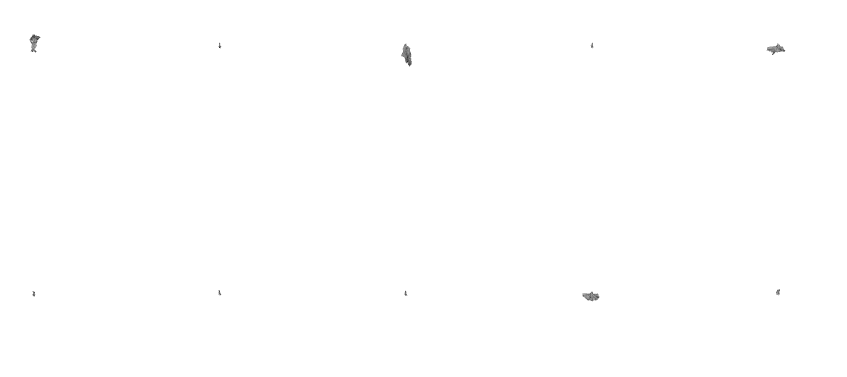
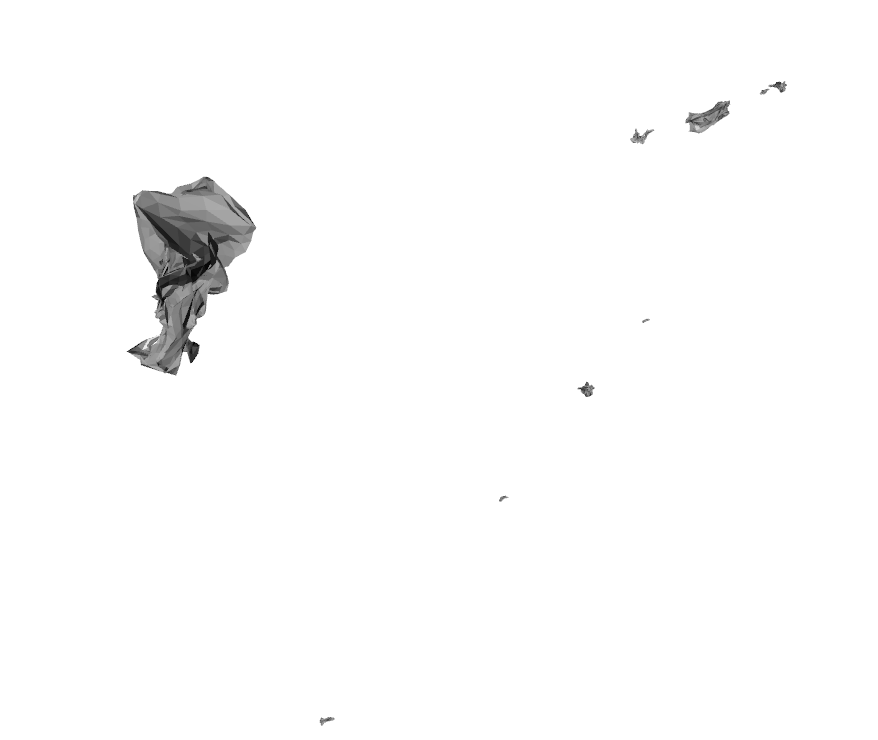

In [46]:
"""Original Data"""
visualize(X_test)

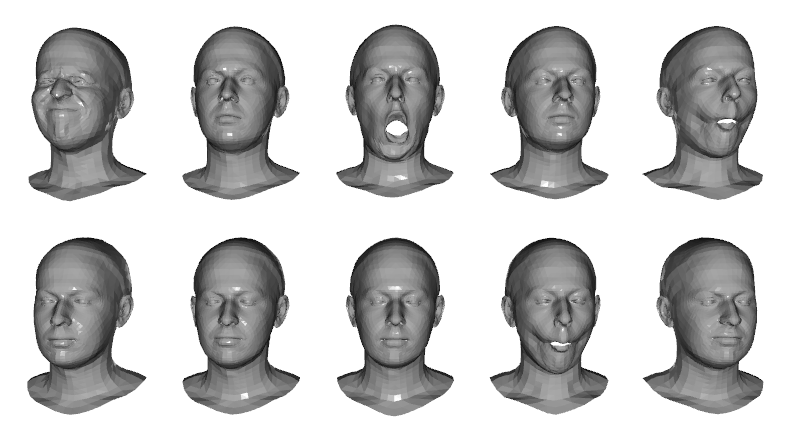

## Modify an Element in Latent Variable

In [49]:
train_pc.shape, test_pc.shape

((1064, 1000), (119, 1000))

In [50]:
trpc_modified = train_pc.copy()
tspc_modified = test_pc.copy()

trpc_modified[0] = 0.2
tspc_modified[0] = 0.2

trpc_modified[10] = 0.3
tspc_modified[10] = 0.3

trpc_modified[100] = 0.4
tspc_modified[100] = 0.4

#### Reconstruct

In [51]:
tr_m_recons = np.matmul(trpc_modified, eigenvectors)
ts_m_recons = np.matmul(tspc_modified, eigenvectors)

tr_m_recons.shape, ts_m_recons.shape

((1064, 15069), (119, 15069))

#### MSE

In [52]:
"""
Mean Squared Error
"""
mse_tr_m_recons = mean_squared_error(X_train_v, tr_m_recons)
mse_ts_m_recons = mean_squared_error(X_test_v, ts_m_recons)

print(f'Modified Train MSE: {mse_tr_m_recons}\nModified Test MSE: {mse_ts_m_recons}')



Modified Train MSE: 0.002543314782763287
Modified Test MSE: 0.00268743582649395


#### Convert to 3D Mesh

In [53]:
tr_m_vertices = np.asarray(reshape_vertices(tr_m_recons))
ts_m_vertices = np.asarray(reshape_vertices(ts_m_recons))
tr_m_vertices.shape, ts_m_vertices.shape

((1064, 5023, 3), (119, 5023, 3))

In [54]:
tr_m_meshes = vertices_to_meshes(tr_m_vertices, X_train)
ts_m_meshes = vertices_to_meshes(ts_m_vertices, X_test)

In [55]:
visualize(ts_m_meshes)

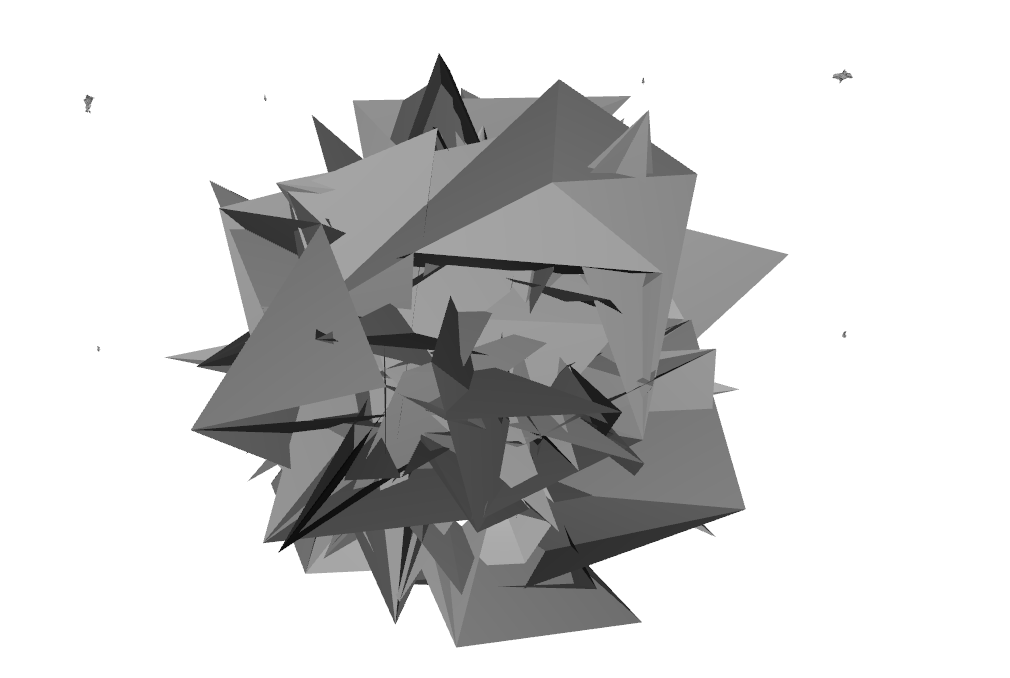

## Visualize 20 Principal Components with Highest Eigenvalues

In [56]:
eigenvals = pca.explained_variance_
highest_20 = eigenvals[:20]
highest_20.shape

(20,)

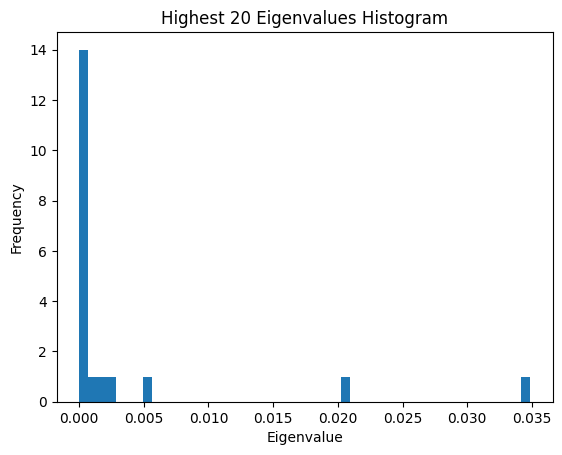

In [57]:
plt.hist(highest_20, bins=50)
plt.title('Highest 20 Eigenvalues Histogram')
plt.ylabel('Frequency')
plt.xlabel('Eigenvalue')
plt.show();